# Project 3
## Instructions

Using any of the three classifiers described in chapter 6 of Natural Language Processing with Python, and any features you can think of, build the best name gender classifier you can. Begin by splitting the Names Corpus into three subsets: 500 words for the test set, 500 words for the dev-test set, and the remaining 6900 words for the training set. Then, starting with the example name gender classifier, make incremental improvements. Use the dev-test set to check your progress. Once you are satisfied with your classifier, check its final performance on the test set. How does the performance on the test set compare to the performance on the dev-test set? Is this what you'd expect?

Source: Natural Language Processing with Python, exercise 6.10.2.

This is NOT a team project as it was stated before.


### 1. Import the Names Corpus

In [76]:
import nltk
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
try:
    nltk.data.find('corpora/names')
except:
    nltk.download('names')

from nltk.corpus import names

### 2. Preparing our data
Starting by creating a list of sets where each set is (name, gender) and then turning it into a pandas dataframe

In [77]:
name_list = ([(name, 'male') for name in names.words('male.txt')] + [(name, 'female') for name in names.words('female.txt')])

names_df = pd.DataFrame(name_list, columns=['name','gender'])
names_df.head()

,name,gender
0,Aamir,male
1,Aaron,male
2,Abbey,male
3,Abbie,male
4,Abbot,male


Below we'll set up some functions to create creatures for our dataset

In [78]:
# Create a features that's the % of word that's vowels
def vowel_proportion(series: pd.Series) -> pd.Series:
    def _ratio(text):
        if not isinstance(text, str) or not text:
            return 0.0
        
        vowel_count = sum(1 for char in text.lower() if char in 'aeiou')
        
        return vowel_count / len(text)

    return series.apply(_ratio)

# Create a features that's the % of the first and last letter being a vowel
def first_last_letter(series: pd.Series) -> pd.Series:
    def _check_ends(text):
        if not isinstance(text, str) or not text:
            return 0.0
            
        text_lower = text.lower()
        vowels = 'aeiou'
        vowel_endpoints = 0
        
        # Check first letter (index 0)
        if len(text_lower) >= 1 and text_lower[0] in vowels:
            vowel_endpoints += 1
            
        # Check last letter (index -1), but only if length is > 1 
        # to avoid double-counting the single character
        if len(text_lower) > 1 and text_lower[-1] in vowels:
            vowel_endpoints += 1
            
        # Proportion is always out of 2 possible positions
        return vowel_endpoints / 2.0

    return series.apply(_check_ends)

# Return an integer of the longest number of vowels in a name
def longest_run_of_vowels(series: pd.Series) -> pd.Series:
    def _max_run(text):
        if not isinstance(text, str):
            return 0
        
        text_lower = text.lower()
        vowels = 'aeiou'
        max_run = 0
        current_run = 0
        
        for char in text_lower:
            if char in vowels:
                current_run += 1
            else:
                # Vowel run is broken, check if it was the longest
                max_run = max(max_run, current_run)
                current_run = 0
                
        # Final check in case the string ends with a vowel run
        return max(max_run, current_run)

    return series.apply(_max_run)

def get_two_last_letters(series: pd.Series) -> pd.Series:
    def _last_letter(text):
        if not isinstance(text, str) or not text:
            return ''
        return text[-2:].lower()
    return series.apply(_last_letter)

In [79]:
def get_gender_features(df: pd.DataFrame) -> pd.DataFrame:
    funciton_list = [
        vowel_proportion,
        first_last_letter,
        longest_run_of_vowels,
        get_two_last_letters
    ]

    # Iterate through each function and apply them to the dataset
    for func in funciton_list:
        feature_name = func.__name__
        df[feature_name] = func(df['name'])
    
    return df

feature_names_df = get_gender_features(names_df)

print(names_df.value_counts('gender'))

names_df.head()

gender
female    5001
male      2943
Name: count, dtype: int64


,name,gender,vowel_proportion,first_last_letter,longest_run_of_vowels,get_two_last_letters
0,Aamir,male,0.6,0.5,2,ir
1,Aaron,male,0.6,0.5,2,on
2,Abbey,male,0.4,0.5,1,ey
3,Abbie,male,0.6,1.0,2,ie
4,Abbot,male,0.4,0.5,1,ot


From the above, we can see our dataset is fairly unbalanced with females making about 62% of the names.

For these numeric fields, we'll create histograms to visualize their distributions and color them based on gender.

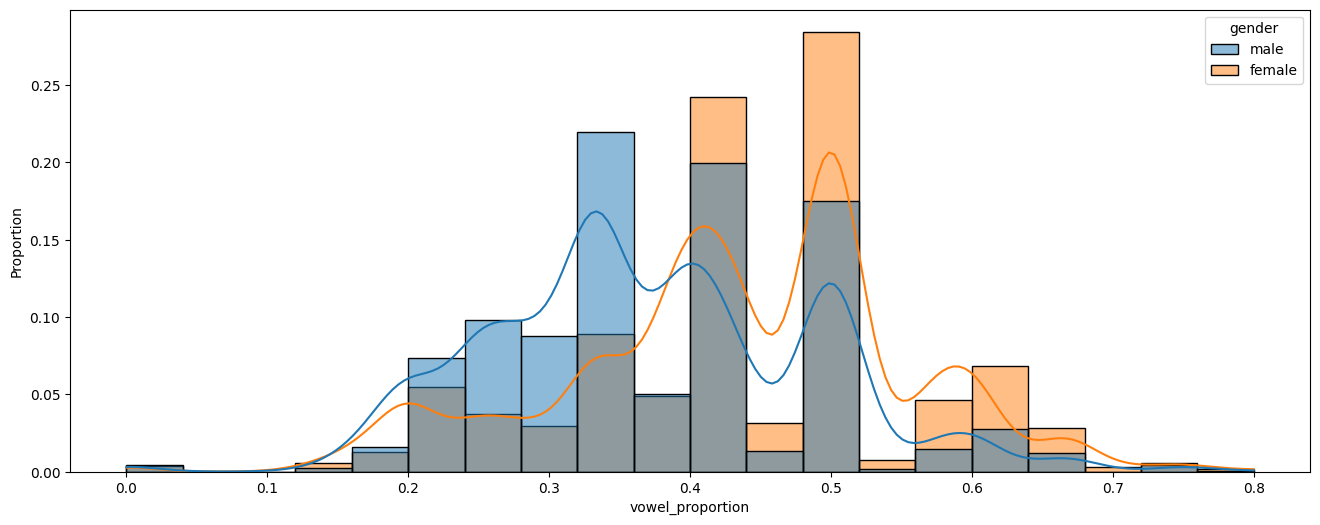

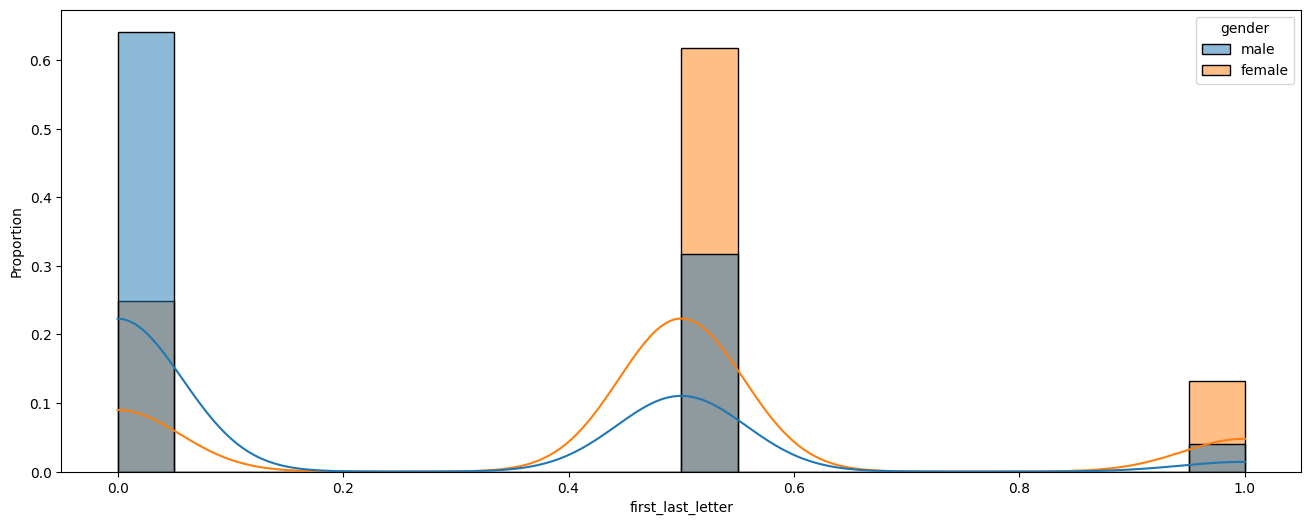

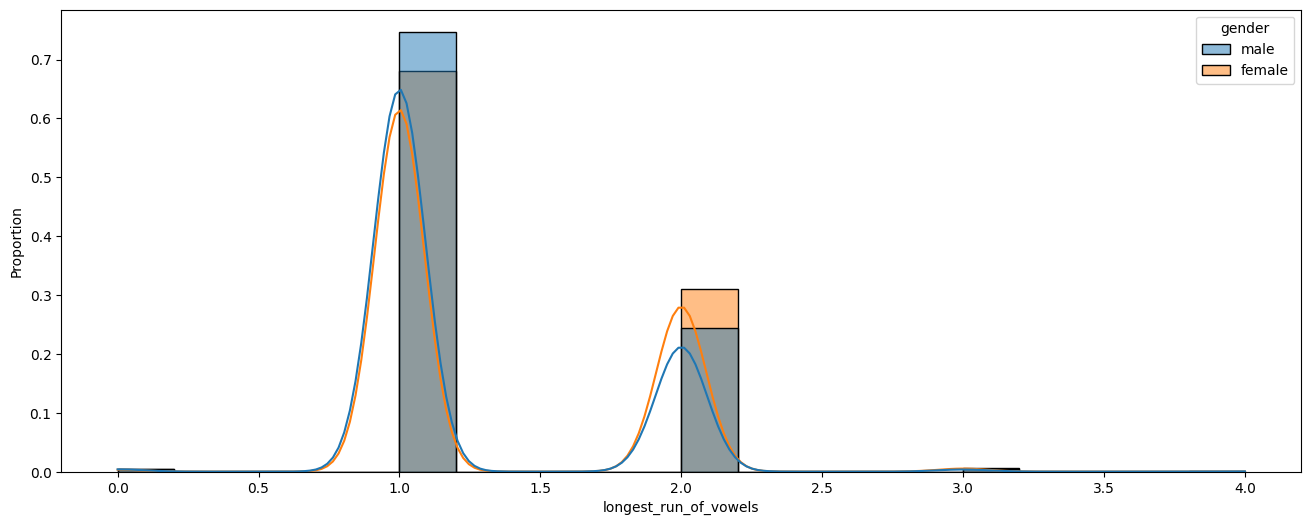

In [80]:
for num_col in names_df.columns:
    if names_df[num_col].dtype in ['int64', 'float64']:
        plt.figure(figsize=(16, 6))
        
        sns.histplot(
            data=names_df,
            x=num_col,
            hue='gender',
            stat="proportion",
            multiple='layer',
            kde=True,
            alpha=0.5,
            bins=20,
            common_norm=False
        )

        plt.show()

From our above histograms we can see that there is a slight difference in the distributions of vowel proportions and in the first and last letter. Although the longest run of vowels does not seem to differ much between genders.

Additionally, we've gotten the last 2 letters categorical features for our model.

### 3. Splitting our data

For our project, we'll split our data into a training and test dataset and balance the data so that there are equal numbers of male and female names

In [86]:
x = names_df.drop('gender', axis=1)
y = names_df['gender']

x_train, x_test, y_train, y_test = train_test_split(
    x, 
    y, 
    test_size=0.2, 
    random_state=1, 
    stratify=y
)

print("\n--- Distribution after Stratified Split (80/20) ---")
print("Training set (X_train, y_train) size:", len(y_train))
print("Test set (X_test, y_test) size:", len(y_test))
print("Training set counts:", Counter(y_train))
print("Test set counts:", Counter(y_test))

# --- 4. Undersample the Majority Class (Female) in the TRAINING Data ONLY ---
# We use RandomUnderSampler, which, by default, sets the majority class 
# count equal to the minority class count (1:1 ratio).
rus = RandomUnderSampler(random_state=42)

# Apply the sampling only to the training set
x_train_resampled, y_train_resampled = rus.fit_resample(x_train, y_train)

# --- 5. Summary of Final Datasets ---
print("\n--- Distribution after Undersampling Training Set ---")
print("New (Balanced) Training set counts:", Counter(y_train_resampled))
print(f"Total balanced training samples: {len(y_train_resampled)}")
print("\nTest set (Unmodified for evaluation):")
print("Test set counts:", Counter(y_test))


--- Distribution after Stratified Split (80/20) ---
Training set (X_train, y_train) size: 6355
Test set (X_test, y_test) size: 1589
Training set counts: Counter({'female': 4001, 'male': 2354})
Test set counts: Counter({'female': 1000, 'male': 589})

--- Distribution after Undersampling Training Set ---
New (Balanced) Training set counts: Counter({'female': 2354, 'male': 2354})
Total balanced training samples: 4708

Test set (Unmodified for evaluation):
Test set counts: Counter({'female': 1000, 'male': 589})


With our datasets prepared, we'll need to convert it into the format expected by NLTK classifiers, which is a list of tuples where each tuple is (feature_dict, label)

In [87]:
def prepare_data_for_nltk(X_df, y_series):
    """Converts Pandas DataFrame/Series to NLTK's required list of (dict, label) tuples."""
    # Convert feature rows into a list of feature dictionaries
    feature_dicts = X_df.to_dict(orient='records')
    # Zip the feature dictionaries with the corresponding labels
    nltk_set = list(zip(feature_dicts, y_series))
    return nltk_set

train_nltk_data = prepare_data_for_nltk(x_train_resampled, y_train_resampled)
test_nltk_data = prepare_data_for_nltk(x_test, y_test)

### 4. Building our models
We'll try a few different models including:
1. NaiveBayesClassifier
2. DecisionTreeClassifier
3. MaxentClassifier

In [93]:
bathroom_classifiers = {
    'NaiveBayes': nltk.NaiveBayesClassifier.train(train_nltk_data),
    'DecisionTree': nltk.DecisionTreeClassifier.train(train_nltk_data),
    'MaxentClassifier': nltk.MaxentClassifier.train(train_nltk_data, max_iter=10)
}

for name, classifier in bathroom_classifiers.items():
    accuracy = nltk.classify.accuracy(classifier, test_nltk_data)
    print(f"{name} Accuracy: {accuracy:.4f}")

  ==> Training (10 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -0.69315        0.500
             2          -0.47546        0.800
             3          -0.39113        0.842
             4          -0.34295        0.876
             5          -0.30980        0.905
             6          -0.28460        0.920
             7          -0.26429        0.929
             8          -0.24730        0.941
             9          -0.23274        0.951
         Final          -0.22004        0.958
NaiveBayes Accuracy: 0.7602
DecisionTree Accuracy: 0.3480
MaxentClassifier Accuracy: 0.7489


On the first round of models with our feature we find that the NaiveBayes classifier is the best performing with an accuracy of 76%.